# Idea

The idea for this memory is to have some background activity ($\beta$) be modulated by the
(TN2 - TB1) computation ($x$, the integrand) as output ($u$) from the PFN neurons:

$$u = x + \beta$$

Dye concentration then changes approximately in proportion to $x$, i.e. represents its integral, i.e.

$$c'(t) = -kc(t) + \phi u(t) = -kc(t) + \phi x(t) + \phi\beta \approx \phi x(t)$$

around its stationary point when idle ($x=0$), $c_0 = \frac{\phi\beta}{k}$.

The input to the post-synaptic neurons is finally weighted by the transmittance ($w(t, c(t))$) through the dye: $y = w \cdot u$.

Since the steering only depends on the phase of the vector in the memory, the goal is that $y \approx f(\int_0^t x(\tau)d\tau)$ for some monotonous $f$. To make this roughly true, $u$ needs to be dominated by the background activity (so that the current value of $x$ doesn't affect the output significantly \[this might perhaps be exploited in some other form of memory which we should also explore\]).

The actual integration of $x$ probably needs to be close to linear so that movements far from the nest are of equal impact to movements far from the nest. This is also a reason for $u$ to be dominated by $\beta$.

While we want $x$ to be insignificant in comparison to $\beta$, we also need its integral to be large enough to affect $y$ more than $x$ itself (i.e. $y \approx w\beta$). To achieve this, we tune the absorption coeffecient $\epsilon$ and the optical path length $l$ to make the transmittance gradient sufficiently steep, exaggerating the effect of the integral of $x$ on the weights. This should be not be a problem, since $w$ being a non-linear function of concentration corresponds to $f$ above.

$k$, of course, needs to be kept small in order for the memory to be stable.


## Parameters

* $\phi$ : transition rate (abstraction of quantum yield)
* $\beta$ : background activity
* $k$ : back-reaction rate coefficient ($s^{-1}$); $k = \frac{\ln{2}}{T_{1/2}}$
* $T_{1/2}$ : back-reaction half-life ($s$)
* $\epsilon$ : molar absorption coefficient ($M^{-1}cm^{-1}$)
* $l \approx 1 - 10 \mu m$ : optical path length ($cm$)
* $c_{tot}$ : total concentration of dye molecules (max $0.3~M$) ($M = mol/L$);

## Intermediates
* $c = [OFF]$ : concentration of molecules in OFF state ($M = mol/L$)
* $[ON] = c_{max} - c$ : **???**
* $A = \epsilon \cdot [ON] \cdot l$ : absorbance (Beer-Lambert law)
* $w = T = 10^{-A}$ : transmittance, i.e. synaptic weight

## Signals
* $x$ : integrand (TN2 - TB1)
* $y$ : output to post-synaptic neurons; ideally $y(t) = \int_0^t x(\tau) d\tau$
* $u = x + \beta$ : output from PFN / CPU4
* $y = wu$

## Dynamics
The concentration changes with two terms:

$$ c'(t) = -kc(t) + \phi u(t) $$

where $-kc$ is the first-order back-reaction and $\phi u$ models the increase in molecules in the OFF state in proportion to the signal (light intensity).

In [376]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import scipy.stats as stats

In [377]:
# Parameters:
phi = 0.00015
beta = 10.0
k = 0.0051
#k = np.log(2) / T_half
epsilon = 2e5
l = 50e-6 * 1e2 # 50 microns, in cm
c_tot = 0.3

mem_gain = 0.1

# Compute stationary point:
c0 = phi * beta / k
print(f"Stationary point: {c0}")
print(f"Half life: {np.log(2) / k} s")

Stationary point: 0.2941176470588235
Half life: 135.91121187449906 s


Let's assume $x=0$:

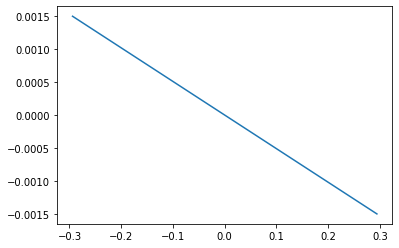

In [395]:
t0 = 0
tf = 100
T = np.linspace(t0, tf, 10000)

# Input:
def x(t):
    return 0*t

# PFN:
def u(t):
    return mem_gain*x(t) + beta

# Concentration dynamics:
def dcdt(t, c):
    return -k * c + phi * u(t)

# Centered around the working point
def dcdt_hat(t, c):
    return -k * (c + c0) + phi * u(t)

# Since x=0, c is time-invariant:
dcdt_in_c = lambda c: dcdt_hat(0.0, c)

cs = np.linspace(0 - c0, 0 + c0, 100)
plt.plot(cs, dcdt_in_c(cs))

The plot above clearly shows how the concentration is drawn towards the stationary point.

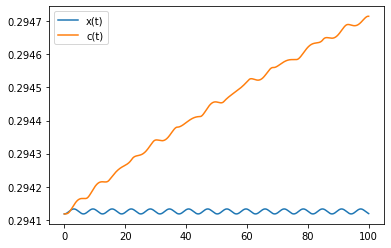

In [398]:
def x(t):
    #return np.ones(np.shape(t))
    return (-np.cos(t) + 1) / 2

solution = solve_ivp(dcdt_hat, y0 = np.array([0]), t_span=(t0, tf), t_eval = T)
c = interp1d(T, solution.y[0] + c0)

plt.plot(T, mem_gain * x(T) * phi + c0, label="x(t)")
plt.plot(T, c(T), label="c(t)")
#plt.plot(T, u(T), label="u(t)")
plt.legend()

The concentration is thus roughly $c \approx a\int_0^t x(\tau) d\tau + b$.



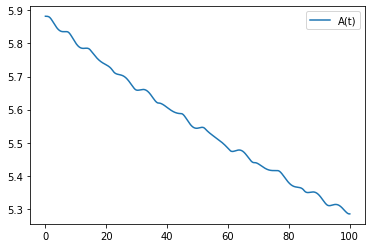

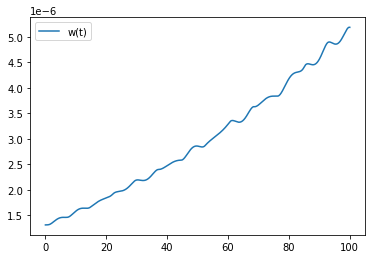

In [401]:
def A(t):
    return epsilon * (c_tot - c(t)) * l

def w(t):
    return 10 ** -A(t)

plt.figure()
plt.plot(T, A(T), label="A(t)")
#plt.plot(T, c(T), label="c(t)")
plt.legend()

plt.figure()
plt.plot(T, w(T), label="w(t)")
#plt.plot(T, c(T), label="c(t)")
plt.legend()

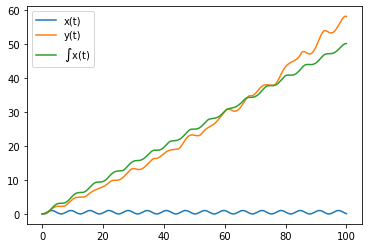

In [402]:
def y(t):
    return w(t) * u(t)

plt.plot(T, x(T), label="x(t)")
plt.plot(T, (y(T) - y(0))*30000*50, label="y(t)")
plt.plot(T, solve_ivp(lambda t, _: x(t), y0=np.array([0]), t_span=(t0, tf), t_eval=T).y[0], label="$\int$x(t)")
plt.legend()
